# Part 0: Setup and Data Extraction

## Set up directories

'rad.ipynb' is the home directory. Please use the "masks" folder produced by Minh in a folder called "mask" along with the dataset in a folder called "train". "train_split_v2.txt" should also belong in the home directory. Additioanl files serve as intermediate points for quality of life handling.

Masks of the training data are available upon request. For generation of novel masks on new test images, please go to 'DataProcessing.ipynb' and follow instructions in that document.



![alt text](https://i.imgur.com/0qVffB1.jpg)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os 
path = os.getcwd()
workdir=os.path.join(path,'drive','My Drive','Colab Notebooks')
print(workdir)
os.chdir(workdir)

/content/drive/My Drive/Colab Notebooks


In [0]:
!pip install pyradiomics

     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 42.5MB 102kB/s 
     |████████████████████████████████| 40kB 6.2MB/s 
     |████████████████████████████████| 4.4MB 42.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: PyWavelets 1.1.1
    Uninstalling PyWavelets-1.1.1:
      Successfully uninstalled PyWavelets-1.1.1


## Run PyRadiomics on four cohorts

Data is first split into four experimental cohorts, then features are extracted.

1.   COVID-19 cohort (89 patients)
2.   Subsampled pneumonia cohort (89 patients)
3.   "Abnormal" cohort formed by combining COVID-19 cohort and pneumonia cohort (178 patients)
4.   Subsampled "normal" cohort (178 patients)

Cohort 1 and 2 will form the dataset for the COVID-19/pneumonia classifier.

Cohort 3 and 4 will form the dataset for the normal/abnormal classifier

If PyRadiomics fails due to a mask segmentation error, please choose a different seed in
```
normlabelssub=normallabels.sample(2*casect, random_state=17)
pneulabelssub=pneumonialabels.sample(casect, random_state=17)
```



In [0]:
import os
import pandas as pd
import radiomics
import SimpleITK as sitk
import cv2

labels=pd.read_csv('train_split_v2.txt', sep=' ', header=None).drop_duplicates()
labels.columns=['n','file','label']
labels.set_index('file')
imgfolder=os.path.join(os.getcwd(),'train')
maskfolder=os.path.join(os.getcwd(),'mask')

normallabels=labels[labels['label']=='normal']
pneumonialabels=labels[labels['label']=='pneumonia']
covidlabels=labels[labels['label']=='COVID-19']

casect=len(covidlabels)
normlabelssub=normallabels.sample(2*casect, random_state=17)
pneulabelssub=pneumonialabels.sample(casect, random_state=17)

abnormallabels=pd.concat([covidlabels,pneulabelssub])

def grayscale(threeimg):
    gray_image = cv2.cvtColor(threeimg, cv2.COLOR_BGR2GRAY)
    return sitk.GetImageFromArray(gray_image)

def radfeatures(filename):
    featurelist=['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_InverseVariance', 'original_glcm_JointAverage', 'original_glcm_JointEnergy', 'original_glcm_JointEntropy', 'original_glcm_MCC', 'original_glcm_MaximumProbability', 'original_glcm_SumAverage', 'original_glcm_SumEntropy', 'original_glcm_SumSquares', 'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_GrayLevelVariance', 'original_gldm_HighGrayLevelEmphasis', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_gldm_LowGrayLevelEmphasis', 'original_gldm_SmallDependenceEmphasis', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_GrayLevelNonUniformityNormalized', 'original_glrlm_GrayLevelVariance', 'original_glrlm_HighGrayLevelRunEmphasis', 'original_glrlm_LongRunEmphasis', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_RunEntropy', 'original_glrlm_RunLengthNonUniformity', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_RunPercentage', 'original_glrlm_RunVariance', 'original_glrlm_ShortRunEmphasis', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_GrayLevelNonUniformityNormalized', 'original_glszm_GrayLevelVariance', 'original_glszm_HighGrayLevelZoneEmphasis', 'original_glszm_LargeAreaEmphasis', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_SizeZoneNonUniformity', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_glszm_SmallAreaEmphasis', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage', 'original_glszm_ZoneVariance', 'original_ngtdm_Busyness', 'original_ngtdm_Coarseness', 'original_ngtdm_Complexity', 'original_ngtdm_Contrast', 'original_ngtdm_Strength']
    maskfile=os.path.join(os.getcwd(),'mask',filename)
    maskimg=sitk.ReadImage(maskfile)
    seg = sitk.BinaryThreshold(maskimg, lowerThreshold=0, upperThreshold=128, insideValue=0, outsideValue=1)
    arr = sitk.GetArrayFromImage(seg)
    mask2 = sitk.GetImageFromArray(arr)
    imgfile=os.path.join(os.getcwd(),'train',filename)
    img=sitk.ReadImage(imgfile)
    arr2 = sitk.GetArrayFromImage(img)
    if len(arr2.shape)!=2:
        img=grayscale(arr2)
    else:
        img=sitk.GetImageFromArray(arr2)
    extractor = radiomics.featureextractor.RadiomicsFeatureExtractor()
    features=extractor.execute(img, mask2)
    featurevalues=[features[x] for x in featurelist]
    return featurevalues

# Features on COVID cases v. penumonia
coviddata=pd.DataFrame()
for filename in covidlabels['file']:
  coviddata[filename]=radfeatures(filename)
pneumdata=pd.DataFrame()
for filename in pneulabelssub['file']:
  pneumdata[filename]=radfeatures(filename)

# Features on abnormal cases v. normal
abnormaldata=pd.DataFrame()
for filename in abnormallabels['file']:
  abnormaldata[filename]=radfeatures(filename)
normdata=pd.DataFrame()
for filename in normlabelssub['file']:
  normdata[filename]=radfeatures(filename)

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

In [0]:
# Save to files to expedite stop point

featurelist=['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_InverseVariance', 'original_glcm_JointAverage', 'original_glcm_JointEnergy', 'original_glcm_JointEntropy', 'original_glcm_MCC', 'original_glcm_MaximumProbability', 'original_glcm_SumAverage', 'original_glcm_SumEntropy', 'original_glcm_SumSquares', 'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_GrayLevelVariance', 'original_gldm_HighGrayLevelEmphasis', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_gldm_LowGrayLevelEmphasis', 'original_gldm_SmallDependenceEmphasis', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_GrayLevelNonUniformityNormalized', 'original_glrlm_GrayLevelVariance', 'original_glrlm_HighGrayLevelRunEmphasis', 'original_glrlm_LongRunEmphasis', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_RunEntropy', 'original_glrlm_RunLengthNonUniformity', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_RunPercentage', 'original_glrlm_RunVariance', 'original_glrlm_ShortRunEmphasis', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_GrayLevelNonUniformityNormalized', 'original_glszm_GrayLevelVariance', 'original_glszm_HighGrayLevelZoneEmphasis', 'original_glszm_LargeAreaEmphasis', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_SizeZoneNonUniformity', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_glszm_SmallAreaEmphasis', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage', 'original_glszm_ZoneVariance', 'original_ngtdm_Busyness', 'original_ngtdm_Coarseness', 'original_ngtdm_Complexity', 'original_ngtdm_Contrast', 'original_ngtdm_Strength']

coviddata=coviddata.transpose()
coviddata.columns=featurelist
coviddata.to_csv('coviddata.csv')

pneumdata=pneumdata.transpose()
pneumdata.columns=featurelist
pneumdata.to_csv('pneumdata.csv')

abnormaldata=abnormaldata.transpose()
abnormaldata.columns=featurelist
abnormaldata.to_csv('abnormaldata.csv')

normdata=normdata.transpose()
normdata.columns=featurelist
normdata.to_csv('normdata.csv')

## Load data from files

If you don't have time to generate radiomics features from scratch or if PyRadiomics fails for other reasons, backup cohorts are provided in the 'pyradiomics_backup' folder. 

In [0]:
import pandas as pd

featurelist=['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_InverseVariance', 'original_glcm_JointAverage', 'original_glcm_JointEnergy', 'original_glcm_JointEntropy', 'original_glcm_MCC', 'original_glcm_MaximumProbability', 'original_glcm_SumAverage', 'original_glcm_SumEntropy', 'original_glcm_SumSquares', 'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_GrayLevelVariance', 'original_gldm_HighGrayLevelEmphasis', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_gldm_LowGrayLevelEmphasis', 'original_gldm_SmallDependenceEmphasis', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_GrayLevelNonUniformityNormalized', 'original_glrlm_GrayLevelVariance', 'original_glrlm_HighGrayLevelRunEmphasis', 'original_glrlm_LongRunEmphasis', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_RunEntropy', 'original_glrlm_RunLengthNonUniformity', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_RunPercentage', 'original_glrlm_RunVariance', 'original_glrlm_ShortRunEmphasis', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_GrayLevelNonUniformityNormalized', 'original_glszm_GrayLevelVariance', 'original_glszm_HighGrayLevelZoneEmphasis', 'original_glszm_LargeAreaEmphasis', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_SizeZoneNonUniformity', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_glszm_SmallAreaEmphasis', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage', 'original_glszm_ZoneVariance', 'original_ngtdm_Busyness', 'original_ngtdm_Coarseness', 'original_ngtdm_Complexity', 'original_ngtdm_Contrast', 'original_ngtdm_Strength']

normal=pd.read_csv('normdata.csv',index_col=0)
abnormal=pd.read_csv('abnormaldata.csv',index_col=0)
pneumdata=pd.read_csv('pneumdata.csv',index_col=0)
coviddata=pd.read_csv('coviddata.csv',index_col=0)

In [0]:
# Generate ground truths of subjects (labels="COVID-19", "pneumonia", "abnormal", "normal")

labels=pd.read_csv('train_split_v2.txt', sep=' ', header=None).drop_duplicates()
labels.columns=['n','file','label']
labels=labels.set_index('file')

def pulllabels(filelist,labeldf):
    labels=[]
    for i in filelist.index:
        labels.append(labeldf.loc[i]['label'])
    return labels

normallabels=pulllabels(normal,labels)
abnormallabels=pulllabels(abnormal,labels)
covidlabels=pulllabels(coviddata,labels)
pneumlabels=pulllabels(pneumdata,labels)

### X, Y are the COVID-19/Pneumonia data. 

### X2, Y2 are the normal/abnormal data

In [0]:
X=pd.concat([coviddata,pneumdata])
Y=[labels.loc[i]['label'] for i in X.index]
for i in range(len(Y)):
    if Y[i] == 'pneumonia':
        Y[i]=0
    if Y[i]=='COVID-19':
        Y[i]=1

In [0]:
X2=pd.concat([normal,abnormal])
Y2=[labels.loc[i]['label'] for i in X2.index]
for i in range(len(Y2)):
    if Y2[i] == 'normal':
        Y2[i]=0
    if Y2[i]=='COVID-19' or Y2[i]=='pneumonia':
        Y2[i]=1

# Part 1: Approach 1 - Naive Random Forest

Grid search is used to identify best hyperparameters for a naive application of random forest onto the radiomics features.

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

## COVID-19 v. Pneumonia

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110, 120, 130],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [5],
    'min_samples_split': [2, 5, 8],
    'n_estimators': [10, 50, 100, 200]
}

rf = RandomForestClassifier()
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = cv, n_jobs = -1, verbose = 2)

covidfit=grid_search.fit(X_train,Y_train)
Y_pred=covidfit.predict(X_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished


*Regarding the relative importance of features: These results can be very unstable and I'm uncomfortable drawing any conclusions from it.*

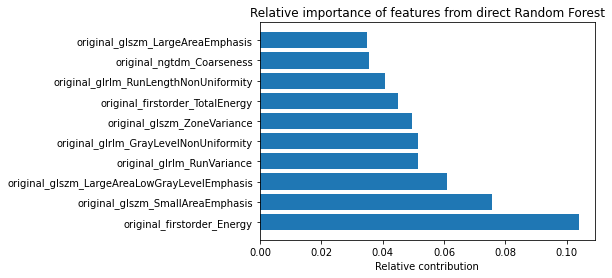

In [0]:
rf_end = RandomForestClassifier(max_depth=covidfit.best_params_['max_depth'],
                                max_features=covidfit.best_params_['max_features'],
                                min_samples_leaf=covidfit.best_params_['min_samples_leaf'], 
                                min_samples_split=covidfit.best_params_['min_samples_split'], 
                                n_estimators=covidfit.best_params_['n_estimators'],)

covidtot=rf_end.fit(X,Y)
covidfeatureimp=dict(zip(covidtot.feature_importances_,featurelist))
topnum=sorted(list(covidfeatureimp.keys()),reverse=True)[0:10]
topfeatures=[covidfeatureimp[d] for d in topnum]

fig, ax = plt.subplots()
fig.ax=plt.subplot()
ax=plt.barh(topfeatures,topnum)
plt.xlabel('Relative contribution')
plt.title('Relative importance of features from direct Random Forest')
plt.show()

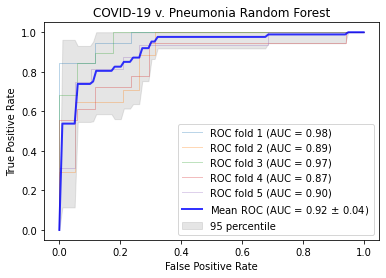

In [0]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, Y)):
    X_train=[X.iloc[u] for u in train]
    X_test=[X.iloc[b] for b in test]
    Y_train=[Y[v] for v in train]
    Y_test=[Y[w] for w in test]
    rf_end.fit(X_train, Y_train)
    viz = plot_roc_curve(rf_end, X_test, Y_test,
                         name='ROC fold {}'.format(i+1),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'95 percentile')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="COVID-19 v. Pneumonia Random Forest")
ax.legend(loc="lower right")
plt.show()

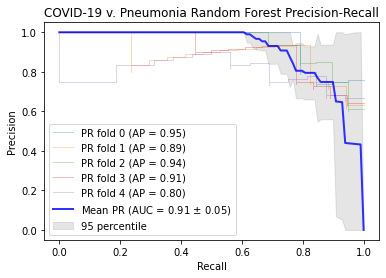

In [0]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, Y)):
    X_train=[X.iloc[u] for u in train]
    X_test=[X.iloc[b] for b in test]
    Y_train=[Y[v] for v in train]
    Y_test=[Y[w] for w in test]
    rf_end.fit(X_train, Y_train)
    viz = plot_precision_recall_curve(rf_end, X_test, Y_test,
                         name='PR fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.precision, viz.recall)
    interp_tpr[0] = 1.0
    tprs.append(interp_tpr)
    aucs.append(viz.average_precision)



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 0.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean PR (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'95 percentile')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="COVID-19 v. Pneumonia Random Forest Precision-Recall")
ax.legend(loc="lower left")
plt.show()

## Normal v. Abnormal

In [0]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

param_grid2 = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110, 120, 130],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [5],
    'min_samples_split': [2, 5, 8],
    'n_estimators': [10, 50, 100, 200]
}

rf2 = RandomForestClassifier()
cv2 = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search2 = GridSearchCV(estimator = rf2, param_grid = param_grid2, 
                          cv = cv2, n_jobs = -1, verbose = 2)

normalfit=grid_search2.fit(X2_train,Y2_train)
# grid_search.best_score_
# grid_search.cv_results_
# grid_search.best_estimator_

Y2_pred=normalfit.predict(X2_test)
f1score2=f1_score(Y2_test,Y2_pred)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished


*Regarding the relative importance of features: These results can be very unstable and I'm uncomfortable drawing any conclusions from it.*

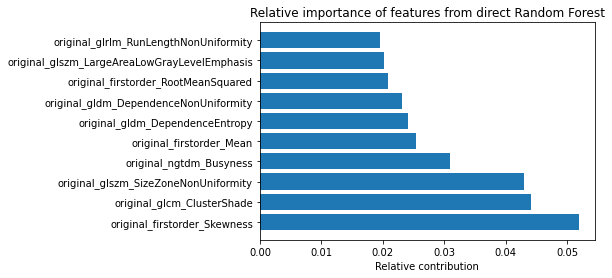

In [0]:
rf_end2 = RandomForestClassifier(max_depth=normalfit.best_params_['max_depth'],
                                max_features=normalfit.best_params_['max_features'],
                                min_samples_leaf=normalfit.best_params_['min_samples_leaf'], 
                                min_samples_split=normalfit.best_params_['min_samples_split'],
                                n_estimators=normalfit.best_params_['n_estimators'],)

normaltot=rf_end2.fit(X2,Y2)
normalfeatureimp=dict(zip(normaltot.feature_importances_,featurelist))
topnum2=sorted(list(normalfeatureimp.keys()),reverse=True)[0:10]
topfeatures2=[normalfeatureimp[d] for d in topnum2]

fig.ax=plt.subplot()
ax=plt.barh(topfeatures2,topnum2)
plt.xlabel('Relative contribution')
plt.title('Relative importance of features from direct Random Forest')
plt.show()

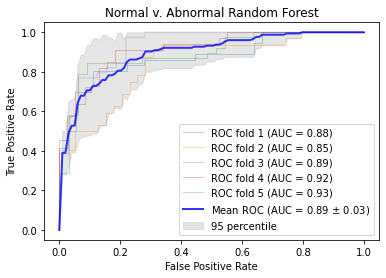

In [0]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X2, Y2)):
    X2_train=[X2.iloc[u] for u in train]
    X2_test=[X2.iloc[b] for b in test]
    Y2_train=[Y2[v] for v in train]
    Y2_test=[Y2[w] for w in test]
    rf_end.fit(X2_train, Y2_train)
    viz = plot_roc_curve(rf_end, X2_test, Y2_test,
                         name='ROC fold {}'.format(i+1),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'95 percentile')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Normal v. Abnormal Random Forest")
ax.legend(loc="lower right")
plt.show()

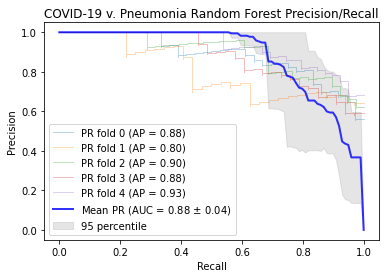

In [0]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X2, Y2)):
    X2_train=[X2.iloc[u] for u in train]
    X2_test=[X2.iloc[b] for b in test]
    Y2_train=[Y2[v] for v in train]
    Y2_test=[Y2[w] for w in test]
    rf_end.fit(X2_train, Y2_train)
    viz = plot_precision_recall_curve(rf_end, X2_test, Y2_test,
                         name='PR fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.precision, viz.recall)
    interp_tpr[0] = 1.0
    tprs.append(interp_tpr)
    aucs.append(viz.average_precision)



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 0.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean PR (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'95 percentile')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="COVID-19 v. Pneumonia Random Forest Precision/Recall")
ax.legend(loc="lower left")
plt.show()

# Part 2: Principal Component Analysis

The logic of using PCA as a prior step before random forest is that random forest, if performed on a large number of features which individually have weak predictive power, the quantity of variance capitalized on by any one branchpoint is weak. If, however, features were aggregated such that the new synthetic features possessed strong predictive value, the random forest should more robustly and quickly identify branch points.

In [0]:
import numpy as np
from scipy.linalg import eig

def eigdecomp(data):
    ata=np.transpose(data)@data
    lam,v=eig(ata)
    return lam,v

def varpercentile(eigenvalues,percent=0.99):
    perteig=[]
    perteig.append(abs(eigenvalues[0]))
    for i in range(1,len(eigenvalues)):
        perteig.append(abs(eigenvalues[i]))
        precentage=sum(perteig[:-1])/sum(perteig[:])
        if precentage>=percent:
            break
    return len(perteig)

def normalize(feature):
    vecmin=min(feature)
    vecrange=(max(feature)-min(feature))
    for i in range(len(feature)):
        feature[i]=(feature[i]-vecmin)/vecrange
    return feature

for i in X.columns:
    X[i]=normalize(X[i])
for i in X2.columns:
    X2[i]=normalize(X2[i])

lcoviddata,vcoviddata=eigdecomp(X)
v2coviddata=abs(vcoviddata[:,:6])
tfX=X@v2coviddata

lcoviddata2,vcoviddata2=eigdecomp(X2)
v2normaldata=abs(vcoviddata2[:,:6])
tfX2=X2@v2normaldata

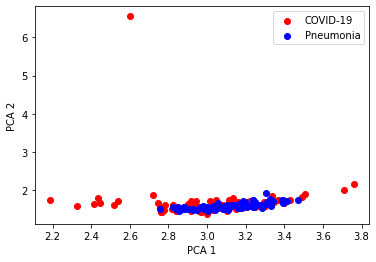

In [0]:
asdf=np.array(tfX)
fig, ax = plt.subplots()
ax.scatter(asdf[0:89,0],asdf[0:89,1],color='red',label='COVID-19')
ax.scatter(asdf[90:,0],asdf[90:,1],color='blue',label='Pneumonia')
plt.legend(loc='upper right')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

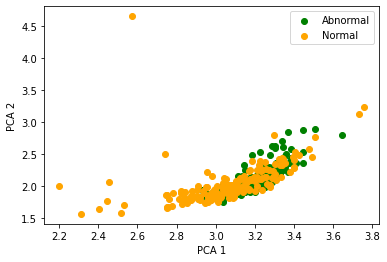

In [0]:
adsf=np.array(tfX2)
fig, ax = plt.subplots()
ax.scatter(adsf[0:178,0],adsf[0:178,1],color='green',label='Abnormal')
ax.scatter(adsf[179:,0],adsf[179:,1],color='orange',label='Normal')
plt.legend(loc='upper right')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

## Composition of principal components

In [0]:
def pullfeatures(v,featurelist):
    vs=np.sort(v)[-10:]
    cs=np.argsort(v)
    cswant=cs[-10:]
    featlist=[]
    for i in cswant:
        featlist.append(featurelist[i])
    return dict(zip(vs,featlist))

Xtopfeatures=pullfeatures(v2coviddata[:,0],featurelist)
X2topfeatures=pullfeatures(v2normaldata[:,0],featurelist)

In [0]:
def importanceplot(featuredict):
  fig.ax=plt.subplot()
  ax=plt.barh(list(featuredict.values()),list(featuredict.keys()))
  plt.xlabel('Relative contribution')
  plt.title('Top ten PyRadiomics features')
  plt.show()

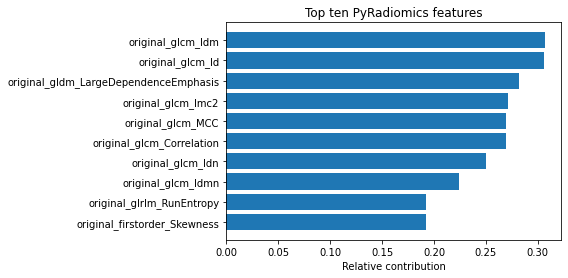

In [0]:
importanceplot(Xtopfeatures)

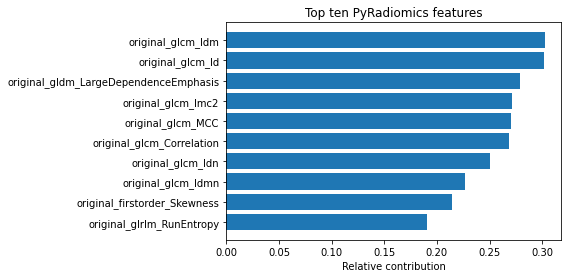

In [0]:
importanceplot(X2topfeatures)

## COVID-19 v. Pneumonia after PCA

In [0]:
#tfX=pd.concat([tfcovid,tfpneumdata])
tfY=[labels.loc[i]['label'] for i in tfX.index]

for i in range(len(tfY)):
    if tfY[i] == 'pneumonia':
        tfY[i]=0
    if tfY[i]=='COVID-19':
        tfY[i]=1

tfX_train, tfX_test, tfY_train, tfY_test = train_test_split(tfX, tfY, test_size=0.2, random_state=42)

param_grid2 = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110, 120, 130],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [5],
    'min_samples_split': [2, 5, 8],
    'n_estimators': [10, 50, 100, 200]
}

rf = RandomForestClassifier()
cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid2, 
                          cv = cv, n_jobs = -1, verbose = 2)

tfcovidfit=grid_search.fit(tfX_train,tfY_train)
tfY_pred=tfcovidfit.predict(tfX_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.1min finished


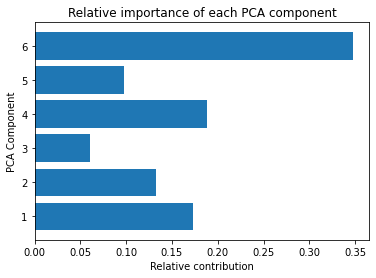

In [0]:
tfrf_end = RandomForestClassifier(max_depth=tfcovidfit.best_params_['max_depth'],
                                max_features=tfcovidfit.best_params_['max_features'],
                                min_samples_leaf=tfcovidfit.best_params_['min_samples_leaf'], 
                                min_samples_split=tfcovidfit.best_params_['min_samples_split'], 
                                n_estimators=tfcovidfit.best_params_['n_estimators'],)

tfcovidtot=tfrf_end.fit(tfX,tfY)
tfcovidfeatureimp=dict(zip(tfcovidtot.feature_importances_,list(range(1,7))))
tftopnum=sorted(list(tfcovidfeatureimp.keys()),reverse=True)
tftopfeatures=[tfcovidfeatureimp[d] for d in tftopnum]

fig.ax=plt.subplot()
ax=plt.barh(tftopfeatures,tftopnum)
plt.xlabel('Relative contribution')
plt.ylabel('PCA Component')
plt.title('Relative importance of each PCA component')
plt.show()

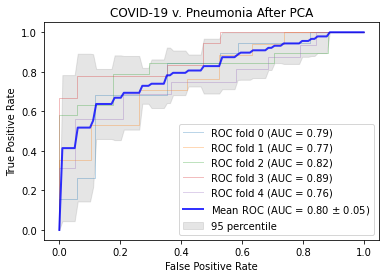

In [0]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(tfX, tfY)):
    tfX_train=[tfX.iloc[u] for u in train]
    tfX_test=[tfX.iloc[b] for b in test]
    tfY_train=[tfY[v] for v in train]
    tfY_test=[tfY[w] for w in test]
    tfrf_end.fit(tfX_train, tfY_train)
    viz = plot_roc_curve(tfrf_end, tfX_test, tfY_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'95 percentile')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="COVID-19 v. Pneumonia After PCA")
ax.legend(loc="lower right")
plt.show()

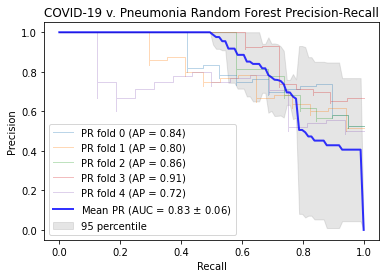

In [0]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(tfX, tfY)):
    tfX_train=[tfX.iloc[u] for u in train]
    tfX_test=[tfX.iloc[b] for b in test]
    tfY_train=[tfY[v] for v in train]
    tfY_test=[tfY[w] for w in test]
    tfrf_end.fit(tfX_train, tfY_train)
    viz = plot_precision_recall_curve(tfrf_end, tfX_test, tfY_test,
                         name='PR fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.precision, viz.recall)
    interp_tpr[0] = 1.0
    tprs.append(interp_tpr)
    aucs.append(viz.average_precision)



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 0.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean PR (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'95 percentile')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="COVID-19 v. Pneumonia Random Forest Precision-Recall")
ax.legend(loc="lower left")
plt.show()

## Normal v. Abnormal after PCA

In [0]:
#tfX2=pd.concat([tfnormal,tfabnormal])
tfY2=[labels.loc[i]['label'] for i in tfX2.index]

for i in range(len(tfY2)):
    if tfY2[i] == 'normal':
        tfY2[i]=0
    if tfY2[i]=='COVID-19' or tfY2[i]=='pneumonia':
        tfY2[i]=1

tfX2_train, tfX2_test, tfY2_train, tfY2_test = train_test_split(tfX2, tfY2, test_size=0.2, random_state=42)

import numpy as np
from sklearn.model_selection import GridSearchCV
 
param_grid2 = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110, 120, 130],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [5],
    'min_samples_split': [2, 5, 8],
    'n_estimators': [10, 50, 100, 200]
}

rf2 = RandomForestClassifier()
cv2 = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search2 = GridSearchCV(estimator = rf2, param_grid = param_grid2, 
                          cv = cv2, n_jobs = -1, verbose = 2)

tfnormalfit=grid_search2.fit(tfX2_train,tfY2_train)
# grid_search.best_score_
# grid_search.cv_results_
# grid_search.best_estimator_

tfY2_pred=tfnormalfit.predict(tfX2_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.1min finished


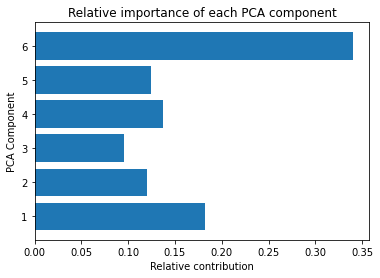

In [0]:
tfrf_end2 = RandomForestClassifier(max_depth=tfnormalfit.best_params_['max_depth'],
                                max_features=tfnormalfit.best_params_['max_features'],
                                min_samples_leaf=tfnormalfit.best_params_['min_samples_leaf'], 
                                min_samples_split=tfnormalfit.best_params_['min_samples_split'], 
                                n_estimators=tfnormalfit.best_params_['n_estimators'],)

tfnormtot=tfrf_end2.fit(tfX,tfY)
tfnormfeatureimp=dict(zip(tfnormtot.feature_importances_,list(range(1,7))))
tftopnum2=sorted(list(tfnormfeatureimp.keys()),reverse=True)
tftopfeatures2=[tfnormfeatureimp[d] for d in tftopnum2]

fig.ax=plt.subplot()
ax=plt.barh(tftopfeatures2,tftopnum2)
plt.xlabel('Relative contribution')
plt.ylabel('PCA Component')
plt.title('Relative importance of each PCA component')
plt.show()

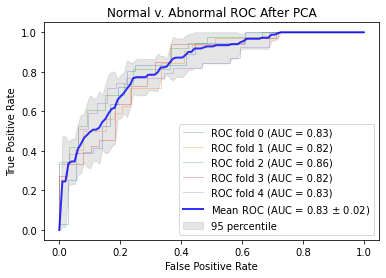

In [0]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv2.split(tfX2, tfY2)):
    tfX2_train=[tfX2.iloc[u] for u in train]
    tfX2_test=[tfX2.iloc[b] for b in test]
    tfY2_train=[tfY2[v] for v in train]
    tfY2_test=[tfY2[w] for w in test]
    tfrf_end2.fit(tfX2_train, tfY2_train)
    viz = plot_roc_curve(tfrf_end2, tfX2_test, tfY2_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'95 percentile')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Normal v. Abnormal ROC After PCA")
ax.legend(loc="lower right")
plt.show()

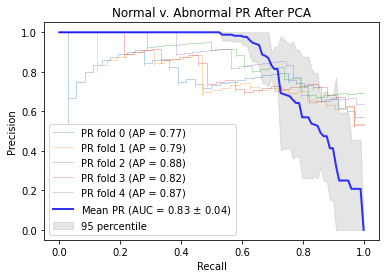

In [0]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(tfX2, tfY2)):
    tfX2_train=[tfX2.iloc[u] for u in train]
    tfX2_test=[tfX2.iloc[b] for b in test]
    tfY2_train=[tfY2[v] for v in train]
    tfY2_test=[tfY2[w] for w in test]
    tfrf_end2.fit(tfX2_train, tfY2_train)
    viz = plot_precision_recall_curve(tfrf_end2, tfX2_test, tfY2_test,
                         name='PR fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.precision, viz.recall)
    interp_tpr[0] = 1.0
    tprs.append(interp_tpr)
    aucs.append(viz.average_precision)



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 0.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean PR (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'95 percentile')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Normal v. Abnormal PR After PCA")
ax.legend(loc="lower left")
plt.show()

# Part 3: Answers to questions

## Question i: Which approach achieved overall better performance and why?

The second approach did not yield any improvement, and in fact yielded worse improvement in the COVID-19 v. pneumonia case. This makes sense, as PCA as a methodology necessarily causes information loss by not capturing 100% of the variance in a graph. The choice of fix features were chosen because it encapsulated 99% of the variance according to the eigenvalues, but in hindsight it appears that the difference translates to notably deterioriating performance.

## Question ii: What are the top 10 clinical + radiomic features that are used by the Random Forest in performing its classification?

![alt text](https://i.imgur.com/SyFRcyb.jpg)

After multiple runs, feature instability was observed from the random forest. This is unsurprising, as the stochastic nature of the feature selection, combined with individually weak predictive power of the features, means the noise component of the variance within a feature could obscure the signal portion of the variance. 

There are features, however, that frequently make the top 10 list. These include original_firstorder_Energy and original_glrlm_GreyLevelNonUniformity, as well as other features relating to brightness or gray-level variance. This does seem to agree intuitively with clinical intuition, as pneumonic individuals tend to develop fibroses or ground glass opacities that would increase brightness or gray-level variance. 

## Question iii: How did you handle the class imbalance for predicting pneumonia versus COVID-19?

I subsampled the pneumonia and normal cases to match their counterparts in the two experimental setups. Particularly, the "abnormal" cohort in the normal v. abnormal experiment was sub-balanced between COVID-19 patients and pneumonia patients. This was chosen to maximize generalizability of the model on normal v. abnormal patients, which is the intention of the classifier.

I had considered whether the 89 COVID-19 patients were sufficient to classify on, and I contemplated using a data generator to create synthetic cases. However, with a baseline stably at ~90% AUC on validation, I did not think that dataset size was a major issue or that my agressiveness in limiting dataset size was fatal to the model.

## Question iv: What further improvements would you make on Approach 2?

The evidence is clear that PCA on this data, at least, provides no improvement because the data itself does not have significant differential variances that exhibit themselves in one or more axes. Thus, I would contemplate a different method for managing the large number of radiomics features generated by PyRadiomics. 

## Acknowledgement

I want to thank Minh Cao for generating masks on the test batch of X-ray images and for his informal contributions on the PCA algorithm.

# Appendix: Running the model on new data

The results above were run on provided datasets along with masks generated by Minh. If new images are to be tested, please run the code below to generate masks.

Ensure the following steps:
1.   Please download 'trained_model.hdf5' from [the GitHub source here](https://github.com/imlab-uiip/lung-segmentation-2d/raw/master/trained_model.hdf5). The model can also be provided upon request. 
2.   Place original X-ray images into the folder 'new_img'
3.   New masks will be generated in 'new_mask'.
4.   Check that GPU's are enabled via 'Edit->Notebook settings'
5.   Run the code in subsection 'Generate masks'
6.   Run the appropriate cell in subsection 'Generate predictions' for predictions.




## Generate Masks

In [0]:
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd
import os
import h5py
from tqdm.notebook import tqdm
from radiomics import featureextractor
import SimpleITK as sitk
import pprint
from scipy import ndimage
import logging
import pprint
# limit gpu memory
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [0]:
def create_dir(path):
    dir_path = Path(path)
    os.makedirs(dir_path, exist_ok = True)
    return dir_path

data_dir = Path('./')
img_dir = create_dir('./new_img')
mask_dir = create_dir('./new_mask')

In [0]:
imgs = os.listdir('new_img')
from skimage import transform, io, img_as_float, exposure

img_arr = []
original_size = []
for i in tqdm(range(len(imgs))):
    img = img_as_float(io.imread(img_dir / imgs[i]))
    if len(img.shape) > 2:
        img = img[:, :, 0]
    original_size.append(img.shape)
    im_shape = (256, 256)
    img = transform.resize(img, im_shape)
    img = exposure.equalize_hist(img)
    img = np.expand_dims(img, -1)
    img_arr.append(img)

In [0]:
## center and standardize img
img_arr = np.array(img_arr)
img_arr -= np.mean(img_arr)
img_arr /= np.std(img_arr)

In [0]:
with h5py.File(data_dir / 'standardized_256x256_data.h5', 'w') as file:
    for i in tqdm(range(img_arr.shape[0])):
        file.create_dataset('img/{:06d}'.format(i), data =img_arr[i])
        file.create_dataset('size/{:06d}'.format(i), data =original_size[i])

In [0]:
img_arr = []
original_size = []
with h5py.File(data_dir / 'standardized_256x256_data.h5', 'r') as file:
    keys = file['img'].keys()
    total = len(keys)
    for i in tqdm(range(total)):
        img_arr.append(file.get('img/{:06d}'.format(i))[:])
        original_size.append(file.get('size/{:06d}'.format(i))[:])
img_arr = np.array(img_arr)
original_size = np.array(original_size)

In [0]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import morphology, color, io, exposure, transform, img_as_bool

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

im_shape = (256, 256)
inp_shape = img_arr[0].shape
model_path = Path('./trained_model.hdf5')
model = load_model(model_path)
test_gen = ImageDataGenerator(rescale=1.)
for img_sample, size, name in tqdm(zip(img_arr, original_size, imgs), total=len(img_arr)):
    # generate mask prediction
    img_sample = np.reshape(img_sample, (1, 256, 256, 1))
    img = exposure.rescale_intensity(np.squeeze(img_sample), out_range=(0,1))
    pred = model.predict(img_sample)[..., 0].reshape(inp_shape[:2])

    # Binarize masks
    pr = pred > 0.5
    
    # Remove regions smaller than 2% of the image
    pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))
   
    # upscale mask to original image
    resized_mask = img_as_bool(transform.resize(pr, size))
    
    # save mask
    im = Image.fromarray(resized_mask)
    im.save(mask_dir / '{}'.format(name))

## Generate predictions

In [0]:
def grayscale(threeimg):
    gray_image = cv2.cvtColor(threeimg, cv2.COLOR_BGR2GRAY)
    return sitk.GetImageFromArray(gray_image)

def radfeatures2(filename):
    featurelist=['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_InverseVariance', 'original_glcm_JointAverage', 'original_glcm_JointEnergy', 'original_glcm_JointEntropy', 'original_glcm_MCC', 'original_glcm_MaximumProbability', 'original_glcm_SumAverage', 'original_glcm_SumEntropy', 'original_glcm_SumSquares', 'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_GrayLevelVariance', 'original_gldm_HighGrayLevelEmphasis', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_gldm_LowGrayLevelEmphasis', 'original_gldm_SmallDependenceEmphasis', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_GrayLevelNonUniformityNormalized', 'original_glrlm_GrayLevelVariance', 'original_glrlm_HighGrayLevelRunEmphasis', 'original_glrlm_LongRunEmphasis', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_RunEntropy', 'original_glrlm_RunLengthNonUniformity', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_RunPercentage', 'original_glrlm_RunVariance', 'original_glrlm_ShortRunEmphasis', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_GrayLevelNonUniformityNormalized', 'original_glszm_GrayLevelVariance', 'original_glszm_HighGrayLevelZoneEmphasis', 'original_glszm_LargeAreaEmphasis', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_SizeZoneNonUniformity', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_glszm_SmallAreaEmphasis', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage', 'original_glszm_ZoneVariance', 'original_ngtdm_Busyness', 'original_ngtdm_Coarseness', 'original_ngtdm_Complexity', 'original_ngtdm_Contrast', 'original_ngtdm_Strength']
    maskfile=os.path.join(os.getcwd(),'new_mask',filename)
    maskimg=sitk.ReadImage(maskfile)
    seg = sitk.BinaryThreshold(maskimg, lowerThreshold=0, upperThreshold=128, insideValue=0, outsideValue=1)
    arr = sitk.GetArrayFromImage(seg)
    mask2 = sitk.GetImageFromArray(arr)
    imgfile=os.path.join(os.getcwd(),'new_img',filename)
    img=sitk.ReadImage(imgfile)
    arr2 = sitk.GetArrayFromImage(img)
    if len(arr2.shape)!=2:
        img=grayscale(arr2)
    else:
        img=sitk.GetImageFromArray(arr2)
    extractor = radiomics.featureextractor.RadiomicsFeatureExtractor()
    features=extractor.execute(img, mask2)
    featurevalues=[features[x] for x in featurelist]
    return featurevalues

newimgfiles=os.listdir(os.path.join(os.getcwd(),'new_img'))

newdata=pd.DataFrame()
for filename in newimgfiles:
  newdata[filename]=radfeatures2(filename)

featurelist=['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_InverseVariance', 'original_glcm_JointAverage', 'original_glcm_JointEnergy', 'original_glcm_JointEntropy', 'original_glcm_MCC', 'original_glcm_MaximumProbability', 'original_glcm_SumAverage', 'original_glcm_SumEntropy', 'original_glcm_SumSquares', 'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_GrayLevelVariance', 'original_gldm_HighGrayLevelEmphasis', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_gldm_LowGrayLevelEmphasis', 'original_gldm_SmallDependenceEmphasis', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_GrayLevelNonUniformityNormalized', 'original_glrlm_GrayLevelVariance', 'original_glrlm_HighGrayLevelRunEmphasis', 'original_glrlm_LongRunEmphasis', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_RunEntropy', 'original_glrlm_RunLengthNonUniformity', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_RunPercentage', 'original_glrlm_RunVariance', 'original_glrlm_ShortRunEmphasis', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_GrayLevelNonUniformityNormalized', 'original_glszm_GrayLevelVariance', 'original_glszm_HighGrayLevelZoneEmphasis', 'original_glszm_LargeAreaEmphasis', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_SizeZoneNonUniformity', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_glszm_SmallAreaEmphasis', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage', 'original_glszm_ZoneVariance', 'original_ngtdm_Busyness', 'original_ngtdm_Coarseness', 'original_ngtdm_Complexity', 'original_ngtdm_Contrast', 'original_ngtdm_Strength']

newdata=newdata.transpose()
newdata.columns=featurelist
newdata.to_csv('newdata.csv')

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

In [0]:
new=pd.read_csv('normdata.csv',index_col=0)
Xn=new
Yn=[labels.loc[i]['label'] for i in Xn.index]

for i in Xn.columns:
    Xn[i]=normalize(Xn[i])

lcoviddata,vcoviddata=eigdecomp(Xn)
v2coviddata=abs(vcoviddata[:,:6])
tfXn=Xn@v2coviddata

In [0]:
# Run this cell if it's COVID-19 v. pneunomia.
# Output is P(COVID-19)

tfYn_pred=tfcovidtot.predict_proba(tfXn)
tfYn_pred[:,1]

In [0]:
# Run this cell if it's normal v. abnormal.
# Output is P(Abnormal)

tfYn_pred2=tfnormtot.predict_proba(tfXn)
tfYn_pred2[:,1]